 _**🍋GAN for Lemon🍋**_
============================
### Create the Lemon Image

||Good Quality|Bad Quality|Empty Background|
|------|------|---|---|
|Image Amount|1125|951|452|
|Show Image|<img width="120px" height="100px" src="https://lh3.google.com/u/0/d/1YIH4UUutMymgwX9AJI-9fzeYlDo5QopA=w200-h190-p-k-nu-iv1">|<img width="120px" height="100px" data-drive-wiz-load-handling="" src="https://lh3.google.com/u/0/d/1-j8jcgZcXuoK9UaTsgbr_Ae3rTmsOjwp=w200-h190-p-k-nu-iv1">|<img width="120px" height="100px" class="l-u-Ab-zb-Ua" data-drive-wiz-load-handling="" src="https://lh3.google.com/u/0/d/14dF8Q5JiqFy-r2g4_300JPE6UqoyS1JQ=w200-h190-p-k-nu-iv1">|


Amount of Bad Quality image is little than Good Quality. You can oversamping the Bad Quality Image. But this code,  Just Create the lemon image.
> If you want to only create the bad quality lemon image. Change the below code 

```python 
lemons=['bad_quality','good_quality']

# If you want to create a bad quality image, change it to
lemons=['bad_quality']
```


**I wrote the code based on the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).**

In [1]:
import os
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader,Dataset
from PIL import Image

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


 _**🍋Unusual Image Visualization🍋**_
============================

Let's visualize representative unusual images. I've summarized the strange images below

**Features :**
1. **[Cirtus Canker](https://www.aphis.usda.gov/aphis/ourfocus/planthealth/plant-pest-and-disease-programs/pests-and-diseases/citrus/citrus-canker)**
2. **Underripe**
3. **[Penicillium digitatum](https://plantdiseasehandbook.tamu.edu/food-crops/fruit-crops/citrus-diseases/)**
4. **Shake**
5. **hole..?**(I don't know how to express)
6. **Combined**
7. **Gray**

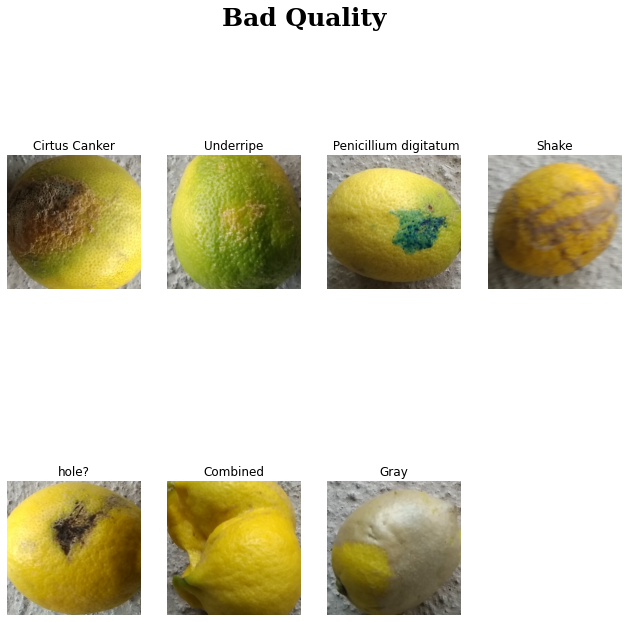

In [2]:
dicts={
    'bad_quality':[66,130,47,280,312,328,383],
}

disease=['Cirtus Canker','Underripe',' Penicillium digitatum', 'Shake','hole?', 'Combined','Gray']


plt.figure(figsize=(11,11))
plt.suptitle('Bad Quality',fontfamily='serif', fontsize=25, fontweight='bold')

for i,dic in enumerate(dicts['bad_quality']):
  plt.subplot(2,4,i+1)
  image=cv2.imread("/kaggle/input/lemon-quality-dataset/lemon_dataset/{0}/{0}_{1}.jpg".format('bad_quality', dic))
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(np.real(image))
  plt.axis('off')
  plt.title(disease[i])

 _**🍋Inputs🍋**_
-------------

* **workers** - the number of worker threads for loading the data with the DataLoader

* **batch** - the batch size used in training. The DCGAN paper uses a batch size of 128

* **image_size** - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details

* **nc** - number of color channels in the input images. For color images this is 3

* **nz** - length of latent vector

* **ngf** - relates to the depth of feature maps carried through the generator

* **ndf** - sets the depth of feature maps propagated through the discriminator

* **epochs** - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer

* **lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002

* **beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5

* **ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs


In [3]:
CFG={
  'workers':2,
  'batch':128,
  'image_size':64,
  'nc':3,
  'nz':100,
  'ngf':64,
  'ndf':64,
  'epochs':160,
  'lr':1e-3,
  'beta1':0.5,
  'ngpu':1    
}

In [4]:
lemons=['bad_quality','good_quality']
image_files=[[os.path.join('/kaggle/input/lemon-quality-dataset/lemon_dataset',lemon,x) for x in os.listdir(os.path.join('/kaggle/input/lemon-quality-dataset/lemon_dataset',lemon))] for lemon in lemons]

In [5]:
images_paths = []
for i in range(2):
    for j in range(len(image_files[i])):
        current = image_files[i]
        images_paths.append(current[j])

 _**🍋Data🍋**_
-------------
Write the dataset code. And display the image.

In [6]:
class CustomDataset(Dataset):
  def __init__(self,image_paths,To_tensor):
    super(CustomDataset,self).__init__()
    self.image_paths=image_paths
    self.To_tensor=To_tensor
  
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self,idx):
    path=self.image_paths[idx]
    image=cv2.imread(path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image=np.asarray(image,dtype=np.uint8)
    
    image=Image.fromarray(image.astype(np.uint8)) 
    image=self.To_tensor(image)
    return image.clone()

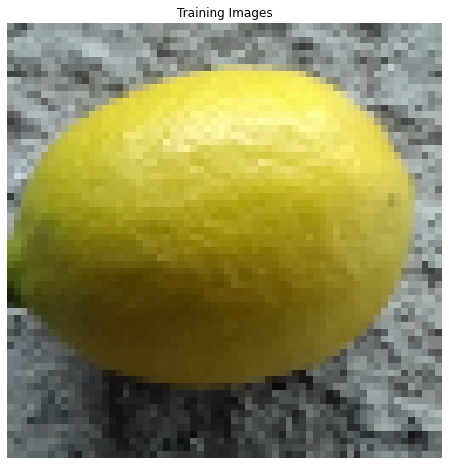

In [7]:
To_tensor=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((CFG['image_size'],CFG['image_size'])),
        transforms.Normalize(        
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),
])

dataset=CustomDataset(images_paths,To_tensor)

dataloader = DataLoader(dataset, batch_size=CFG['batch'],
                                         shuffle=True, num_workers=CFG['workers'])

device = torch.device("cuda:0" if (torch.cuda.is_available() and CFG['ngpu'] > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

 _**🍋Weight Initialization🍋**_
-------------
 > From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.  <br> **-Pytorch Tutorial**

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

 _**🍋Generator🍋**_
-------------
 > The generator, GG, is designed to map the latent space vector (zz) to data-space. Since our data are images, converting zz to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [-1,1][−1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.  <br> **-Pytorch Tutorial**


 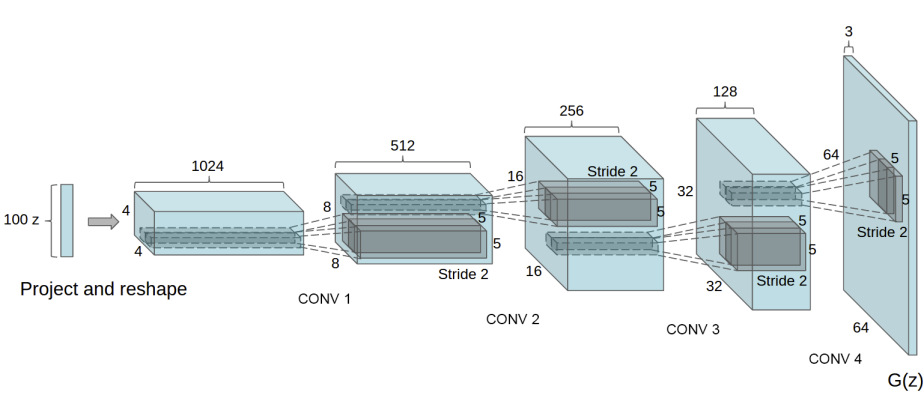

Notice, how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( CFG['nz'], CFG['ngf'] * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(CFG['ngf'] * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(CFG['ngf'] * 8, CFG['ngf'] * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(CFG['ngf'] * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( CFG['ngf'] * 4, CFG['ngf'] * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(CFG['ngf'] * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( CFG['ngf'] * 2, CFG['ngf'], 4, 2, 1, bias=False),
            nn.BatchNorm2d(CFG['ngf']),
            nn.ReLU(True),
            nn.ConvTranspose2d( CFG['ngf'], CFG['nc'], 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netG = Generator(CFG['ngpu']).to(device)

if (device.type == 'cuda') and (CFG['ngpu'] > 1):
    netG = nn.DataParallel(netG, list(range(CFG['ngpu'])))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


 _**🍋Discriminator🍋**_
-------------
 > The generator, GG, is designed to map the latent space vector (zz) to data-space. Since our data are images, converting zz to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [-1,1][−1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.  <br> **-Pytorch Tutorial**

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(CFG['nc'], CFG['ndf'], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(CFG['ndf'], CFG['ndf'] * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(CFG['ndf'] * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(CFG['ndf'] * 2, CFG['ndf'] * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(CFG['ndf'] * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(CFG['ndf'] * 4, CFG['ndf'] * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(CFG['ndf'] * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(CFG['ndf'] * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = Discriminator(CFG['ngpu']).to(device)

if (device.type == 'cuda') and (CFG['ngpu'] > 1):
    netD = nn.DataParallel(netD, list(range(CFG['ngpu'])))


netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, CFG['nz'], 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=CFG['lr'], betas=(CFG['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=CFG['lr'], betas=(CFG['beta1'], 0.999))

In [14]:

img_list = []
img_list_zero=[]
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(CFG['epochs']):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, CFG['nz'], 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, CFG['epochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == CFG['epochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list_zero.append(vutils.make_grid(fake[0], padding=2, normalize=True))
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/160][0/17]	Loss_D: 1.7955	Loss_G: 18.7510	D(x): 0.4877	D(G(z)): 0.5501 / 0.0000
[1/160][0/17]	Loss_D: 0.4551	Loss_G: 7.8432	D(x): 0.8267	D(G(z)): 0.0040 / 0.0079
[2/160][0/17]	Loss_D: 5.8032	Loss_G: 7.8035	D(x): 0.9476	D(G(z)): 0.9399 / 0.0074
[3/160][0/17]	Loss_D: 4.0999	Loss_G: 8.7746	D(x): 0.8564	D(G(z)): 0.8483 / 0.0041
[4/160][0/17]	Loss_D: 1.1810	Loss_G: 0.7915	D(x): 0.4381	D(G(z)): 0.1106 / 0.5092
[5/160][0/17]	Loss_D: 2.4466	Loss_G: 4.0443	D(x): 0.8468	D(G(z)): 0.8102 / 0.0362
[6/160][0/17]	Loss_D: 1.6886	Loss_G: 1.1165	D(x): 0.4973	D(G(z)): 0.5096 / 0.3648
[7/160][0/17]	Loss_D: 1.0133	Loss_G: 1.6730	D(x): 0.5706	D(G(z)): 0.2661 / 0.2266
[8/160][0/17]	Loss_D: 1.0963	Loss_G: 1.4576	D(x): 0.7468	D(G(z)): 0.4711 / 0.2896
[9/160][0/17]	Loss_D: 2.0189	Loss_G: 3.6138	D(x): 0.9260	D(G(z)): 0.7704 / 0.0485
[10/160][0/17]	Loss_D: 2.0142	Loss_G: 3.8174	D(x): 0.8785	D(G(z)): 0.7659 / 0.0528
[11/160][0/17]	Loss_D: 1.6359	Loss_G: 3.8216	D(x): 0.6601	D(G(z)): 0.5

 _**🍋Results🍋**_
-------------


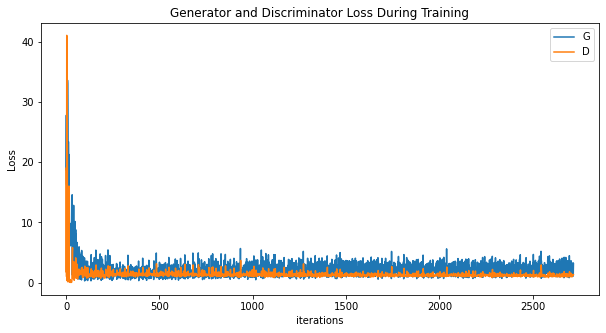

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


Comparison of real and fake images🍋

(Right : Real image, Left: Fake image) 

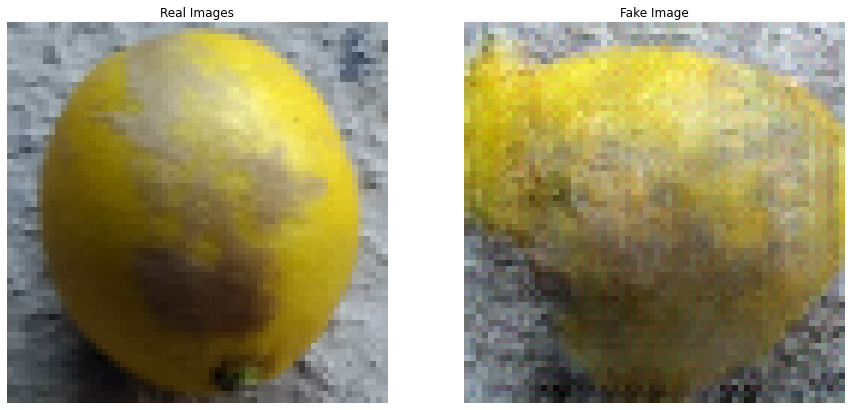

In [16]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Image")
plt.imshow(np.transpose(img_list_zero[-1],(1,2,0)))
plt.show()

You can check fake images.

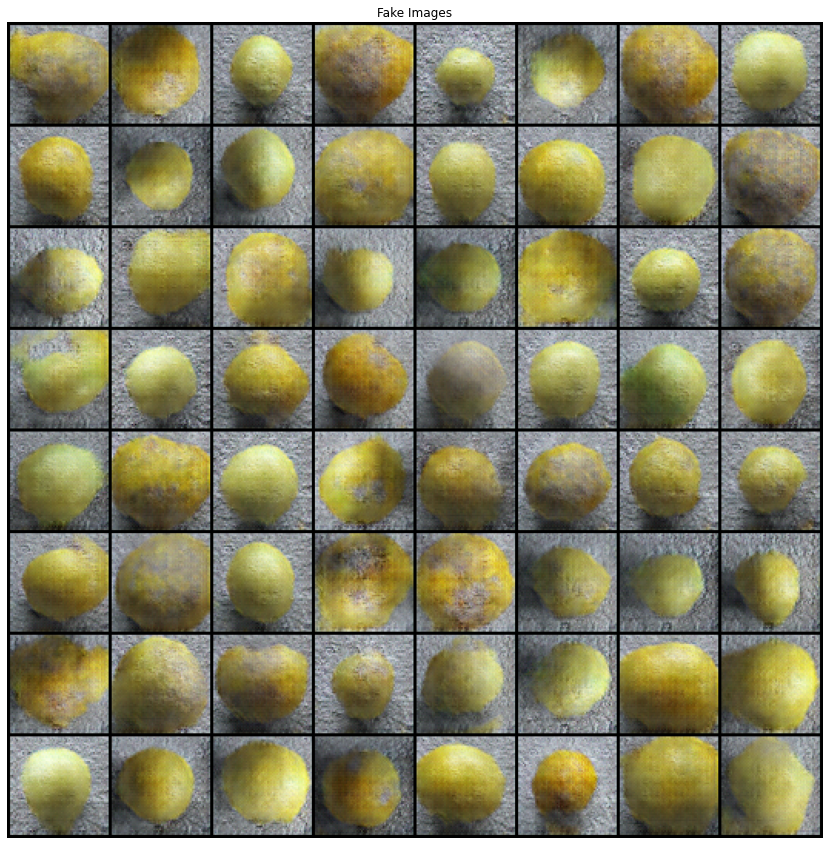

In [17]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Advice and questions are always welcome.**